In [1]:
import os

from autocvd import autocvd
autocvd(num_gpus = 1)

# os.environ['CUDA_VISIBLE_DEVICES'] = '4, 6, 9, 7'  # Set the visible GPUs

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding
# jax.config.update("jax_enable_x64", True)  # Enable 64-bit precision

import matplotlib.pyplot as plt


import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL
from odisseo.initial_condition import Plummer_sphere, ic_two_body, sample_position_on_sphere, inclined_circular_velocity, sample_position_on_circle, inclined_position
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})



In [2]:
code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  
# code_units = CodeUnits(code_length, code_mass, G=G)  # default values


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 500, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.05 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)


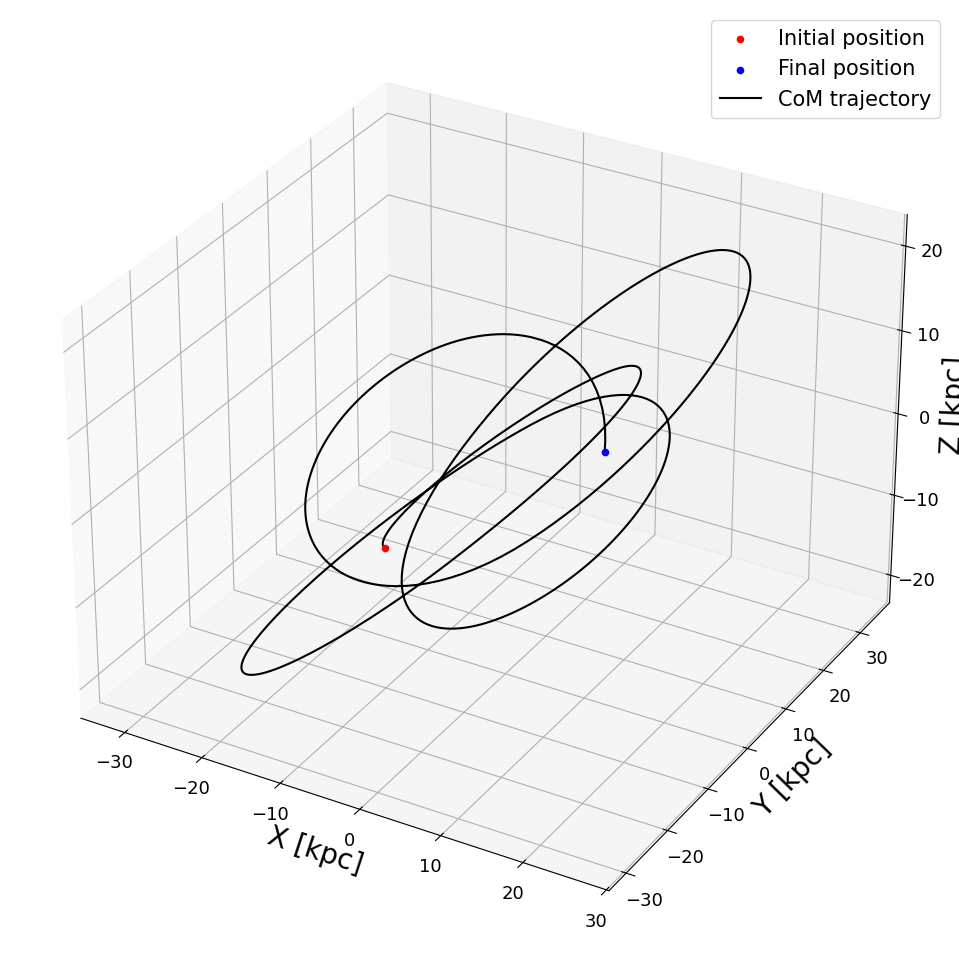

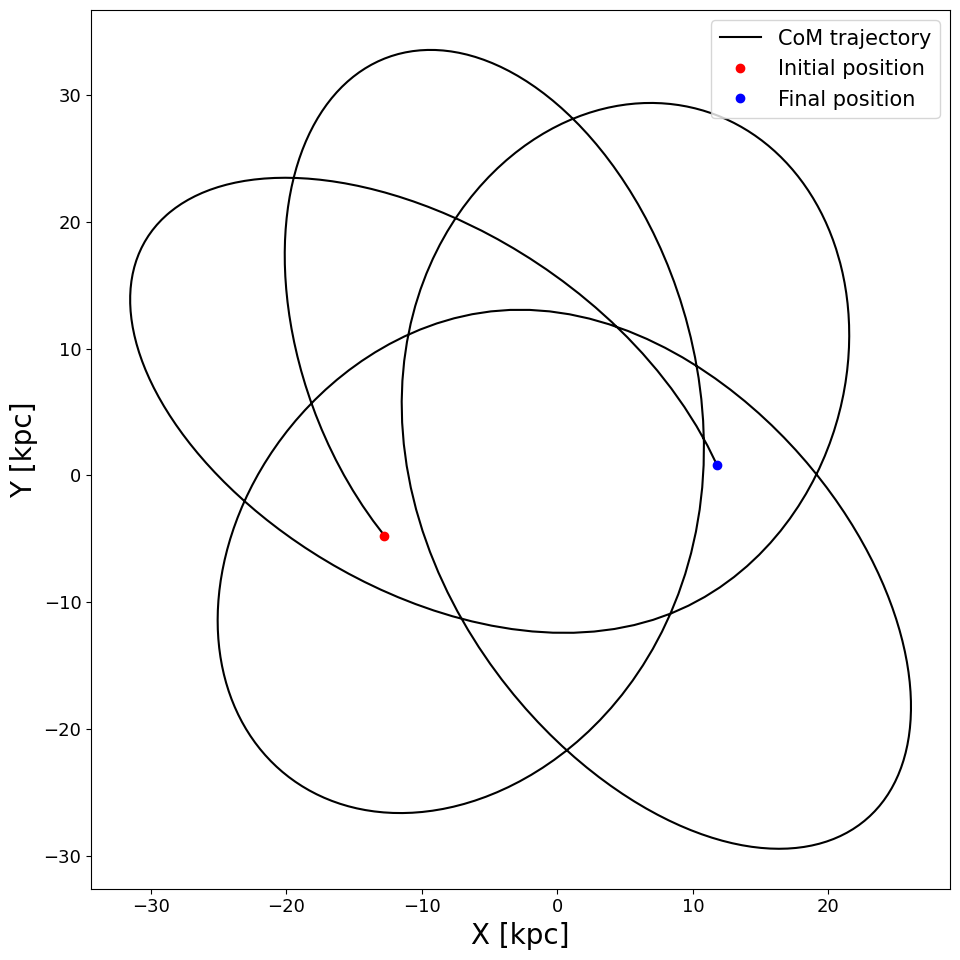

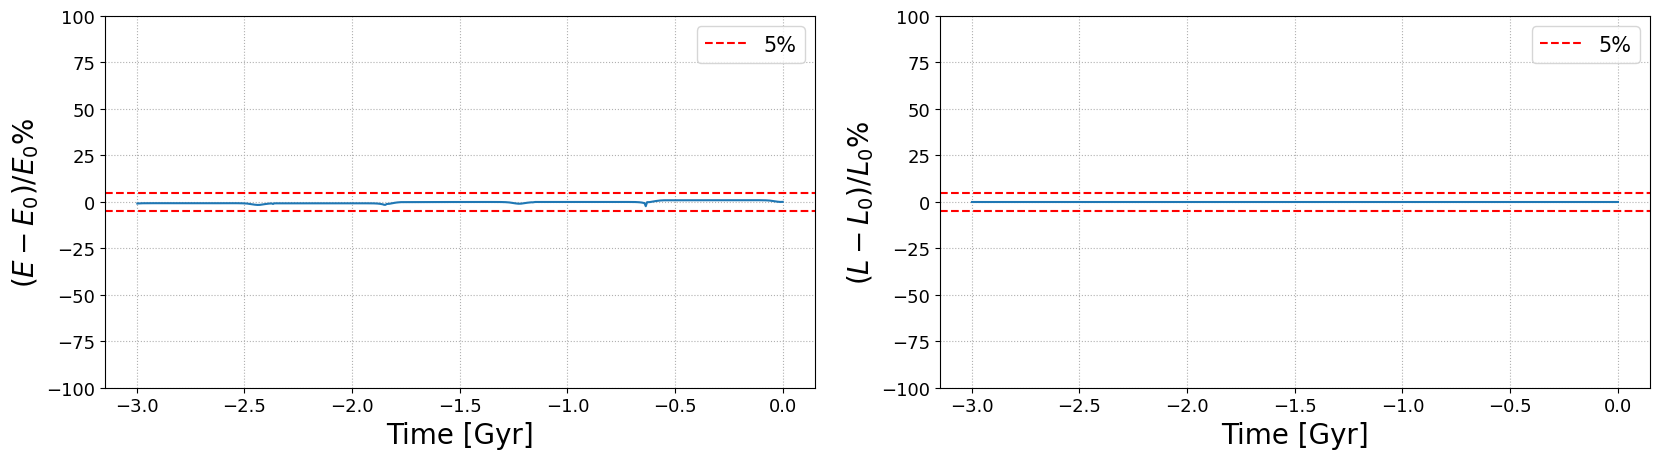

In [3]:
#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,return_snapshots=True,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
# pos_com_final = jnp.array([[12.4, 1.5, 7.1]]) * u.kpc.to(code_units.code_length)
# vel_com_final = jnp.array([[107.0, -243.0, -105.0]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]

##### CoM orbit plot####
fig = plt.figure(figsize=(15, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[-1,0, 0, 2]* code_units.code_length.to(u.kpc),c='r', label='Initial position')
ax.scatter(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 
           snapshots_com.states[0,0, 0, 2]* code_units.code_length.to(u.kpc), c='b', label='Final position')
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:,0, 0, 2]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_zlabel("Z [kpc]")
ax.legend()
plt.show()

fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'k-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
        snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.legend()

energy_angular_momentum_plot(snapshots_com, code_units,)

# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

In [4]:
#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

In [5]:
# mesh = Mesh(np.array(jax.devices()), ("i",))
# initial_state_sharded = jax.device_put(initial_state_stream, NamedSharding(mesh, PartitionSpec("i")))
# mass_sharded = jax.device_put(mass, NamedSharding(mesh, PartitionSpec("i")))
snapshots = time_integration(initial_state_stream, mass, config, params)

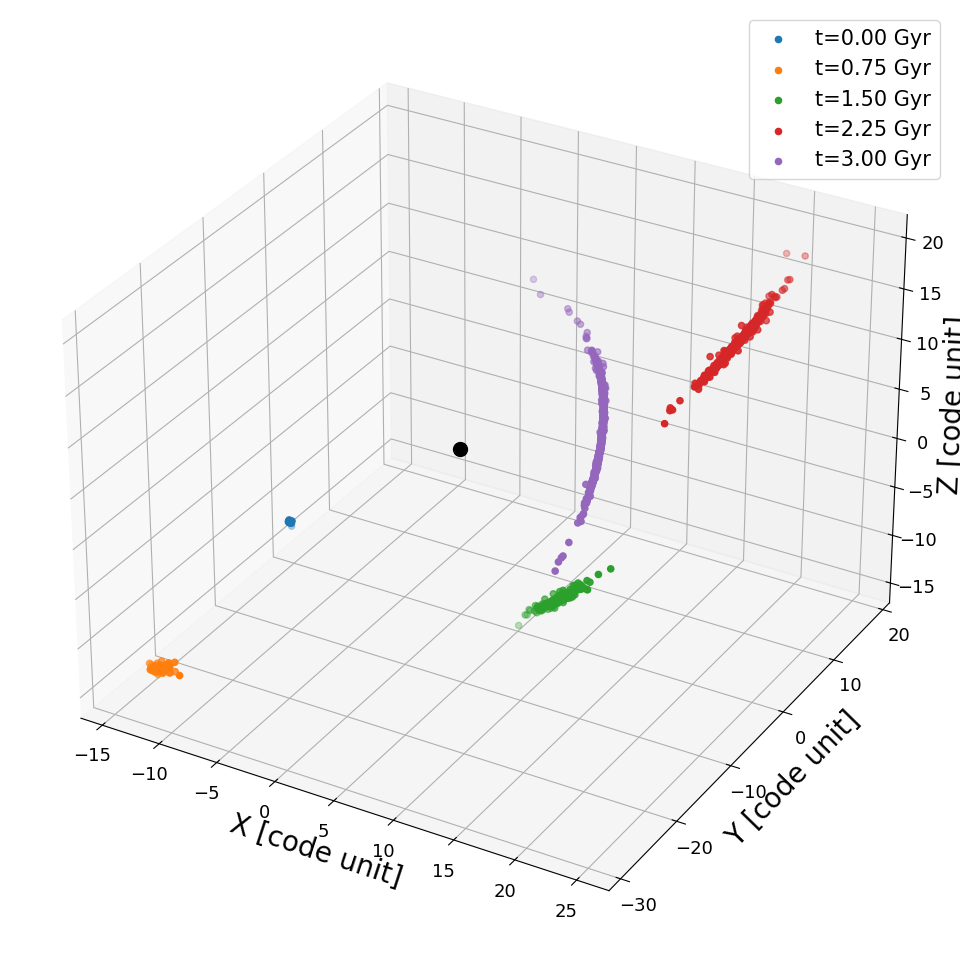

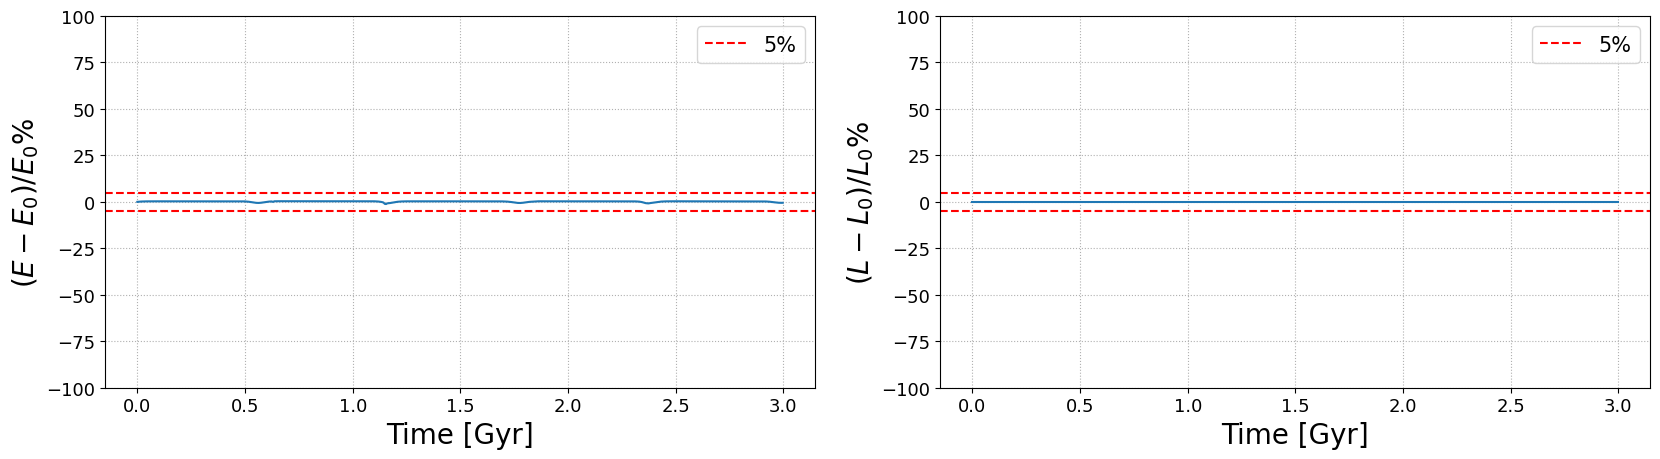

In [6]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111, projection='3d')
for i in np.linspace(0, config.num_snapshots, 5, dtype=int):
    ax.scatter(snapshots.states[i, :, 0, 0] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 1] * code_units.code_length.to(u.kpc), 
               snapshots.states[i, :, 0, 2] * code_units.code_length.to(u.kpc), label=f"t={(snapshots.times[i]*code_units.code_time).to(u.Gyr):.2f}")
ax.scatter(0, 0, 0, c='k', s=100, )
ax.set_xlabel('X [code unit]')
ax.set_ylabel('Y [code unit]')
ax.set_zlabel('Z [code unit]')
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
# ax.set_zlim(-30, 30)
ax.legend()


energy_angular_momentum_plot(snapshots, code_units,)


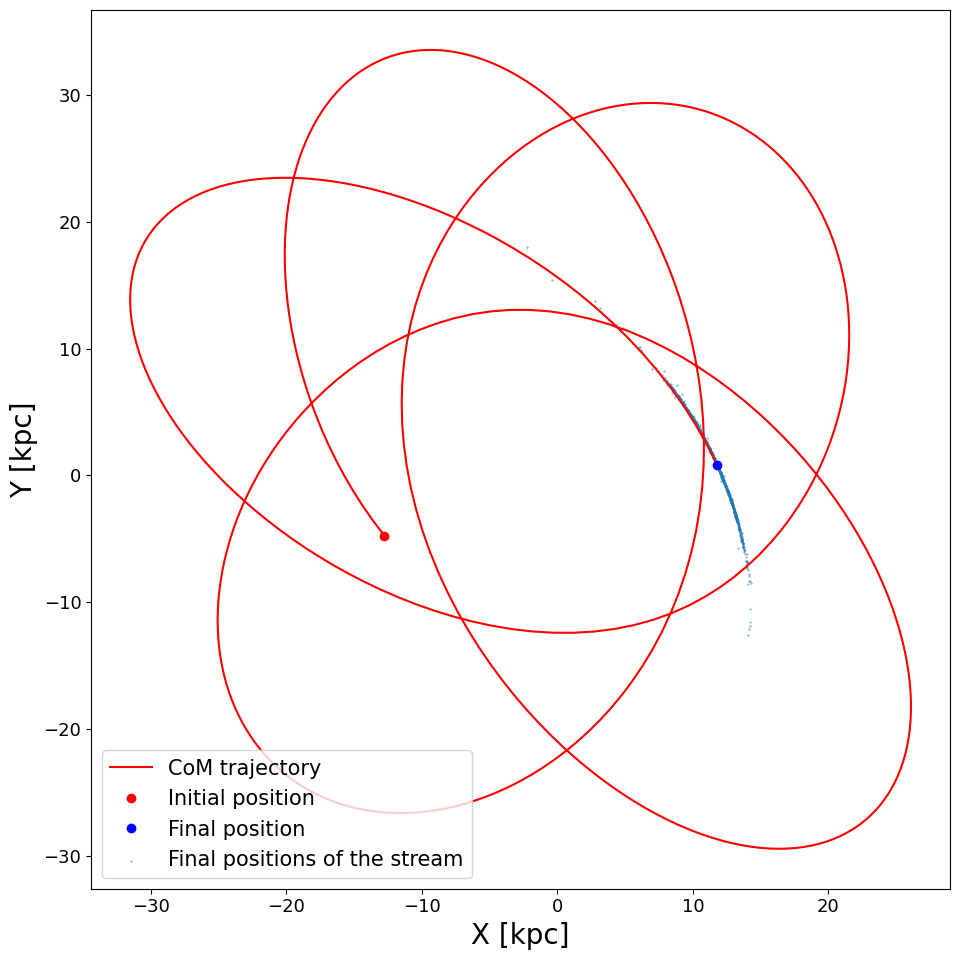

In [7]:
fig = plt.figure(figsize=(10, 10), tight_layout=True)
ax = fig.add_subplot(111)
ax.plot(snapshots_com.states[:, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[:, 0, 0, 1]* code_units.code_length.to(u.kpc), 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[-1, 0, 0, 1]* code_units.code_length.to(u.kpc), 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots_com.states[0, 0, 0, 1]* code_units.code_length.to(u.kpc), 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]* code_units.code_length.to(u.kpc), 
    snapshots.states[-1, :, 0, 1]* code_units.code_length.to(u.kpc), s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
# ax.set_xlim(-30, 30)
# ax.set_ylim(-30, 30)
ax.legend()

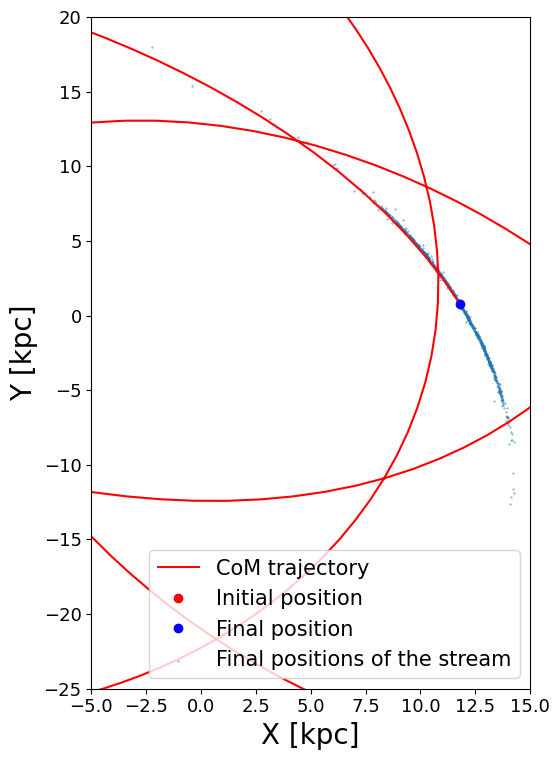

In [8]:
fig = plt.figure(figsize=(6, 8), tight_layout=True)
ax = fig.add_subplot(111)
conversion = code_units.code_length.to(u.kpc)
ax.plot(snapshots_com.states[:, 0, 0, 0]*conversion, 
        snapshots_com.states[:, 0, 0, 1]* conversion, 'r-', label='CoM trajectory')
ax.plot(snapshots_com.states[-1, 0, 0, 0]*conversion,
         snapshots_com.states[-1, 0, 0, 1]*conversion, 'ro', label='Initial position')
ax.plot(snapshots_com.states[0, 0, 0, 0]*conversion, 
        snapshots_com.states[0, 0, 0, 1]*conversion, 'bo', label='Final position')
ax.scatter(snapshots.states[-1, :, 0, 0]*conversion, 
           snapshots.states[-1, :, 0, 1]*conversion, s=0.1, label='Final positions of the stream')
ax.set_xlabel("X [kpc]")
ax.set_ylabel("Y [kpc]")
ax.set_xlim(-5, 15)
ax.set_ylim(-25, 20)
ax.legend()

In [9]:
final_state = snapshots.states[-1].copy()
final_positions, final_velocities = final_state[:, 0], final_state[:, 1]

final_positions = final_positions * code_units.code_length.to(u.kpc)
final_velocities = final_velocities * code_units.code_velocity.to(u.kpc / u.Myr)

(-250.0, 250.0)

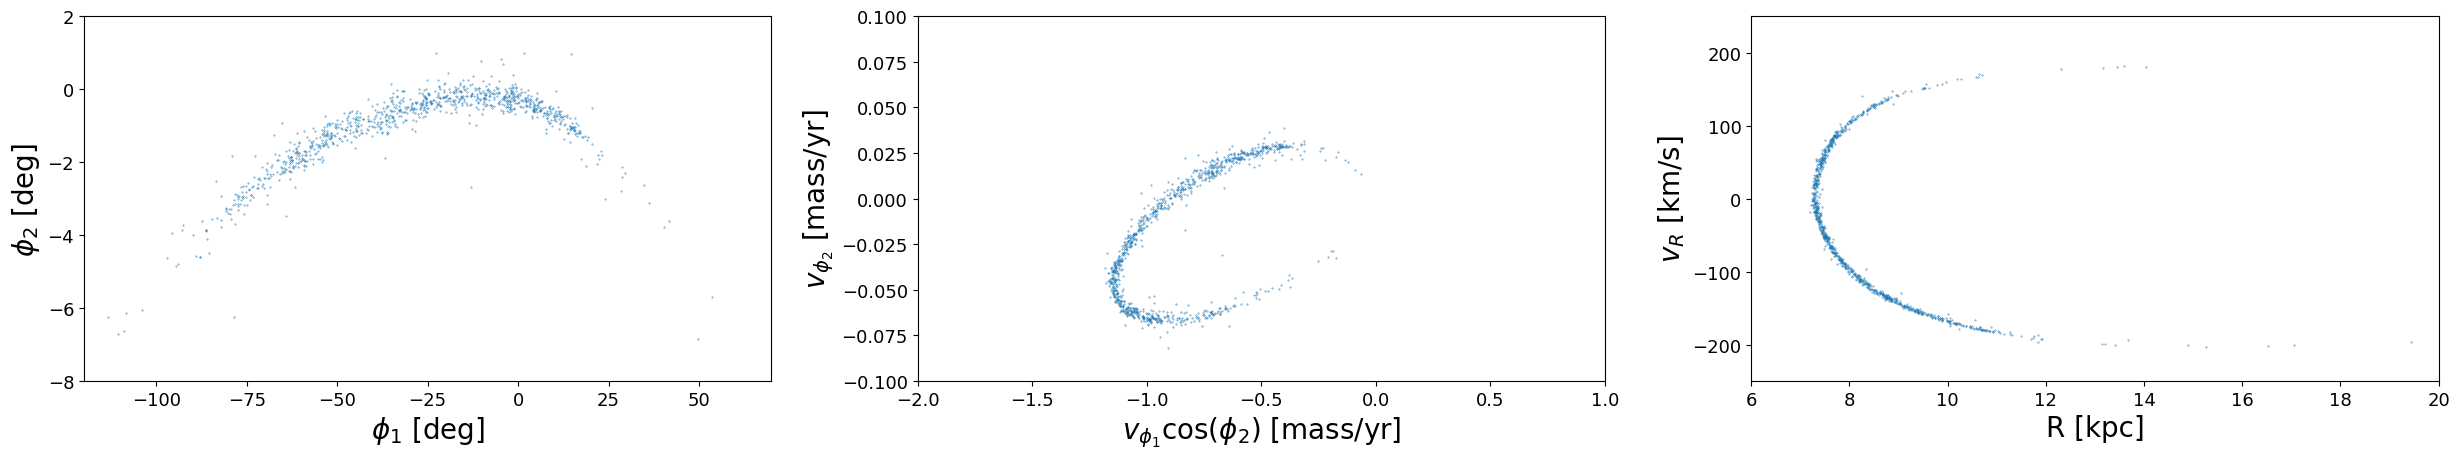

In [10]:
s = projection_on_GD1(final_state, code_units=code_units,)
R = s[:, 0]  # kpc
phi1 = s[:, 1]  # deg
phi2 = s[:, 2]  # deg
vR = s[:, 3]  # km/s
v1_cosphi2 = s[:, 4]  # mass/yr
v2 = s[:, 5]  # mass/yr

fig = plt.figure(figsize=(25, 5), tight_layout=True)

ax = fig.add_subplot(131)
ax.scatter(phi1, phi2, s=0.1)
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

ax = fig.add_subplot(132)
ax.scatter(v1_cosphi2 ,
           v2 ,
            s=0.1)
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mass/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mass/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)

ax = fig.add_subplot(133)
ax.scatter(R, vR , s=0.1)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)


/tmp/ipykernel_400472/3570116978.py:21: RuntimeWarning: divide by zero encountered in log10
  im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
/tmp/ipykernel_400472/3570116978.py:31: RuntimeWarning: divide by zero encountered in log10
  im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
/tmp/ipykernel_400472/3570116978.py:40: RuntimeWarning: divide by zero encountered in log10
  im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')


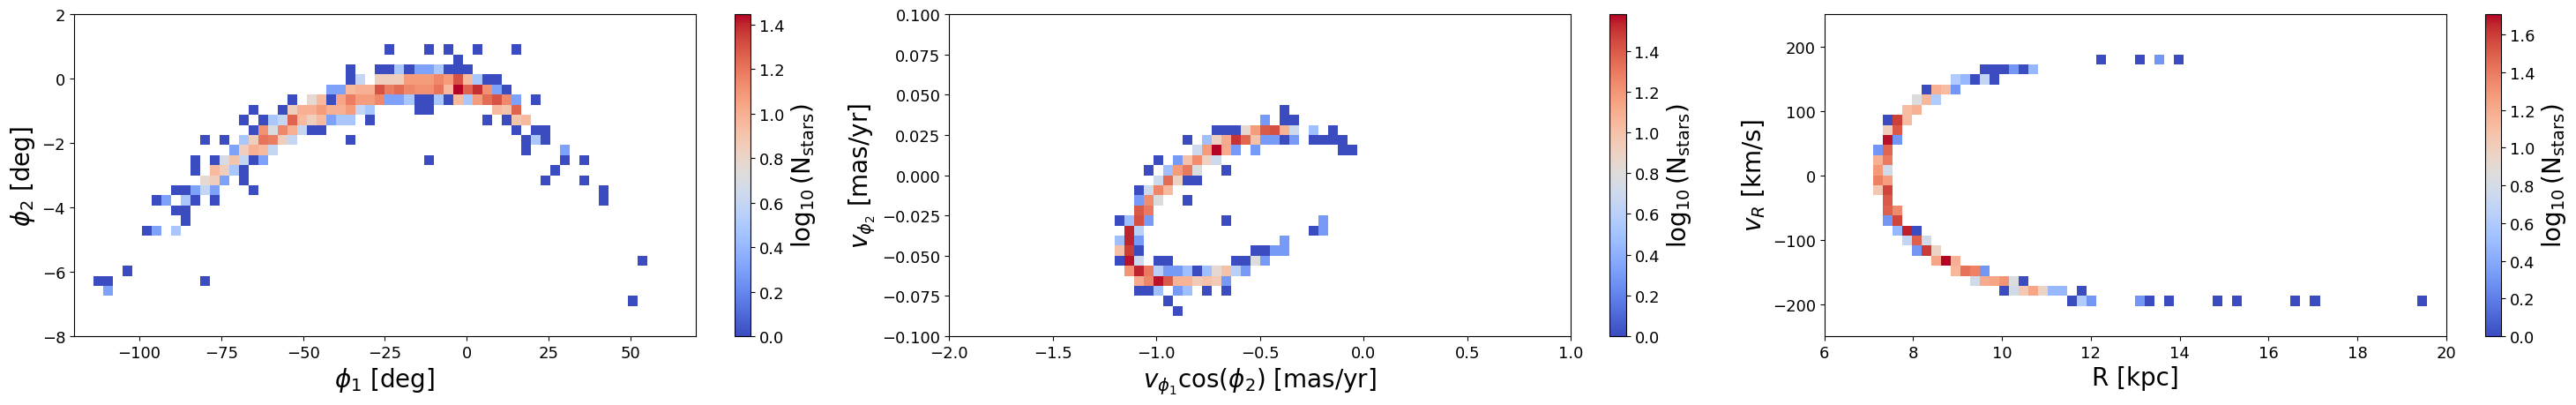

In [11]:
import matplotlib.colors as colors

fig = plt.figure(figsize=(30, 5), tight_layout=True)

# Define bin edges and create meshgrids
phi1_bins = jnp.linspace(-120, 70, 65)    # 64 bins
phi2_bins = jnp.linspace(-8, 2, 33)       # 32 bins
v1_bins = jnp.linspace(-2., 1.0, 65)      # 64 bins  
v2_bins = jnp.linspace(-0.10, 0.10, 33)   # 32 bins
R_bins = jnp.linspace(6, 20, 65)          # 64 bins
vR_bins = jnp.linspace(-250, 250, 33)     # 32 bins

# Create meshgrids for bin edges (not centers)
PHI1, PHI2 = jnp.meshgrid(phi1_bins, phi2_bins, indexing='ij')
V1, V2 = jnp.meshgrid(v1_bins, v2_bins, indexing='ij')
R_GRID, VR_GRID = jnp.meshgrid(R_bins, vR_bins, indexing='ij')

# Create 2D histograms
ax = fig.add_subplot(131)
counts1 = jnp.histogram2d(phi1, phi2, bins=[phi1_bins, phi2_bins])[0]
im1 = ax.pcolormesh(PHI1, PHI2, np.log10(counts1), cmap='coolwarm')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)
# Define a normalization that centers white at 0
plt.colorbar(im1, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$',  )

ax = fig.add_subplot(132)
counts2 = jnp.histogram2d(v1_cosphi2, v2, bins=[v1_bins, v2_bins])[0]
im2 = ax.pcolormesh(V1, V2, np.log10(counts2), cmap='coolwarm')
ax.set_xlabel("$v_{\phi_1}\cos(\phi_2)$ [mas/yr]")
ax.set_ylabel("$v_{\phi_2}$ [mas/yr]")
ax.set_xlim(-2., 1.0)
ax.set_ylim(-0.10, 0.10)
plt.colorbar(im2, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

ax = fig.add_subplot(133)
counts3 = jnp.histogram2d(R, vR, bins=[R_bins, vR_bins])[0]
im3 = ax.pcolormesh(R_GRID, VR_GRID, np.log10(counts3), cmap='coolwarm')
ax.set_xlabel("R [kpc]")
ax.set_ylabel("$v_R$ [km/s]")
ax.set_xlim(6, 20)
ax.set_ylim(-250, 250)
plt.colorbar(im3, ax=ax, label=r'$\log_{10}(\text{N}_{\text{stars}})$')

(-8.0, 2.0)

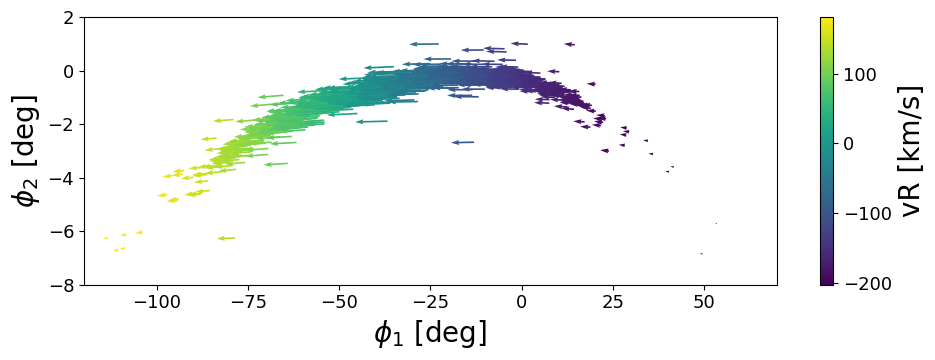

In [12]:
# Plotting the vector field of velocities
fig  = plt.figure(figsize=(10, 4), tight_layout=True)
ax = fig.add_subplot(111)
vectorf_field = ax.quiver(phi1, 
                            phi2,
                            v1_cosphi2/jnp.cos(jnp.deg2rad(phi2)),
                            v2,
                            vR,
                            scale=25,)
plt.colorbar(vectorf_field, ax=ax, label='vR [km/s]')
ax.set_xlabel("$\phi_1$ [deg]")
ax.set_ylabel("$\phi_2$ [deg]")
ax.set_xlim(-120, 70)
ax.set_ylim(-8, 2)

In [13]:
target_stream = projection_on_GD1(snapshots.states[-1, :], code_units=code_units ) # Reshape to (N_particles, 6)
target_stream.shape

(1000, 6)

# 1D case

## Brute force searching 

Gradient of the total mass of the t_end:
 1.6608803
Loss:
 0.021259183


Text(0, 0.5, 'Loss')

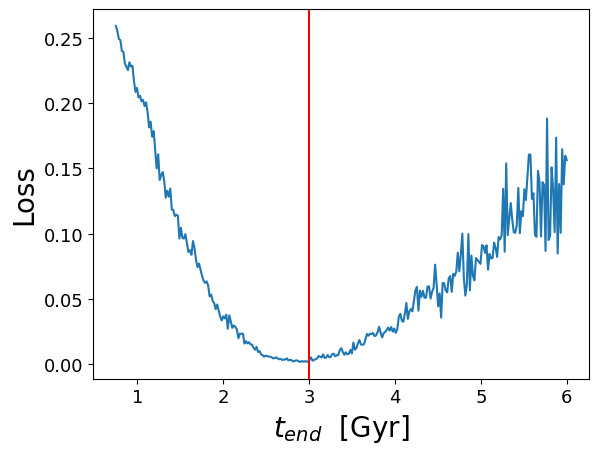

In [14]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

target_norm, mean, std = normalize_stream_data(stream_target)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy


@jit
def time_integration_tend_grad(t_end, key):

    #Creation of the Plummer sphere requires a key 
    # key = random.PRNGKey(key)

    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params_com = params_com._replace(t_end = -t_end,)
    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    N_background = int(1e6)
    #Generate the probability of selectin a background star
    background_selected = jnp.where(jax.random.uniform(key=key, shape=(N_background,)) < 1e-3, 1.0, 0.0)
    keys = random.split(key, N_background)
    # selected_background = jax.vmap(lambda key, background_star: jnp.where(background_star, background_assignement(key), jnp.nan))(keys, background_selected)

    # Combine the selected stream and background stars
    # stream = jnp.concatenate((selected_stream, selected_background), axis=0)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=jax.random.key(0), shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream
    # log_prob = flow.log_prob((stream-stream_mean)/stream_std)  # Subtract the mean and divde by the std for normalization

    # loss = -jnp.sum(log_prob)
    # loss = -jnp.sum(jnp.where(log_prob < 0, log_prob, 0))
    # loss = -jnp.mean(log_prob)

     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])
        
    # def normalize_stream(stream):
    #     # Normalize each dimension to [0,1]
    #     return (stream - bounds[:, 0]) / (bounds[:, 1] - bounds[:, 0])
    
    
    sim_norm = (stream - mean)/std
    
    # Adaptive bandwidth for 6D data
    # n_sim, n_target = len(stream), len(stream_target)
    # # sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    # sigma = 2 * jnp.power(n_sim + n_target, -1/(6+4))    # sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D

    # # Compute MMD terms
    # xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    # yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    # xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    # return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.1, 0.3, 0.25, 0.25])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)


# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = params.t_end*(3/4) 
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(time_integration_tend_grad, )(t_end, key)
print("Gradient of the total mass of the t_end:\n", grad)
print("Loss:\n", loss)  
n_sim = 299
keys = random.split(random.PRNGKey(0), n_sim+1)
t_end = np.linspace(params.t_end*(1/4), params.t_end*(8/4), n_sim) 
# Correct way to append - assign the result back to Mvir
t_end = np.concatenate([t_end, np.array([params.t_end])]) # Append the true Mvir value
t_end = jnp.array(np.sort(t_end))

# loss, grad = jax.vmap(jax.value_and_grad(time_integration_NFW_mass_grad))(Mvir, keys)

mesh = Mesh(np.array(jax.devices()), ("i",))
t_end_sharded = jax.device_put(jnp.log10(t_end), NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_NFW_tend_map(t_end_and_key):
    t_end, key = t_end_and_key
    t_end = 10**t_end
    return jax.value_and_grad(time_integration_tend_grad)(t_end, key)

loss, grad = jax.lax.map(
    time_integration_NFW_tend_map, 
    (t_end_sharded, keys_sharded), 
    batch_size=1,
)

plt.figure()
plt.plot(t_end*(code_units.code_time).to(u.Gyr), loss)
plt.axvline(params.t_end*(code_units.code_time).to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$  [Gyr]")
plt.ylabel('Loss')
# plt.savefig('./loss_landscape/loss_landscape_t_end.pdf')


In [15]:
# hessian = jax.hessian(time_integration_tend_grad, )(jnp.array(params.t_end), random.PRNGKey(0))
print("Hessian:\n", hessian)

NameError: name 'hessian' is not defined

In [16]:
print(t_end[jnp.argmin(loss)] * code_units.code_time.to(u.Gyr), "Gyr")

2.8993287 Gyr


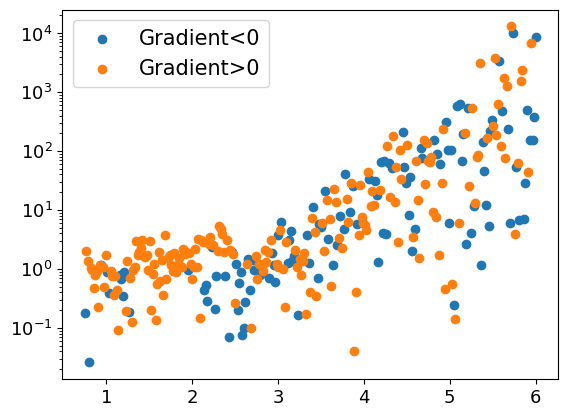

In [17]:
plt.scatter(t_end[grad<0]*(code_units.code_time).to(u.Gyr) , abs(grad[grad<0]), label='Gradient<0')
plt.scatter(t_end[grad>0]*(code_units.code_time).to(u.Gyr), abs(grad[grad>0]), label='Gradient>0')
plt.plot()
plt.yscale('log')
plt.legend()

## Gradient descent around the minimum

In [29]:
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm

# We pick gradient descent for pedagogical and visualization reasons.
# In practice one would use e.g. Levenberg-Marquardt from the
# optimistix package.

# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(-f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

In [30]:
@jit
def time_integration_t_endlog(t_end, key):
    """Wrapper function to compute the loss for a given t_end."""
    t_end = 10**t_end  # Convert log scale back to original scale
    return time_integration_tend_grad(t_end, key)

In [31]:
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_t_endlog, 
    np.log10(t_end[jnp.argmin(loss)]),  
    random.PRNGKey(32), 
    learning_rate=0.01,
    tol=1e-6, 
    max_iter=200)

  0%|          | 0/200 [00:00<?, ?it/s]

 47%|████▋     | 94/200 [01:39<01:52,  1.06s/it] 


In [32]:
x1 = 10**x1  # Convert back to original scale
xlist= 10**jnp.array(xlist)  # Convert back to original scale

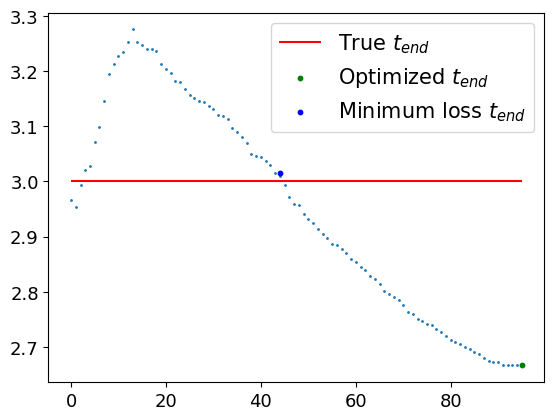

In [33]:
plt.scatter(jnp.arange(len(xlist[1:])), 
            jnp.array([xlist[1:]])*code_units.code_time.to(u.Gyr),
            s=1  )
plt.hlines(y=params.t_end*code_units.code_time.to(u.Gyr), xmin=0, xmax=len(xlist[1:]) , label='True $t_{end}$', color='r')
plt.scatter(len(xlist[1:]), 
            x1*code_units.code_time.to(u.Gyr), s=10, label='Optimized $t_{end}$', color='g')
plt.scatter(np.argmin(loss_list[1:]),
            xlist[np.argmin(loss_list[1:])]*code_units.code_time.to(u.Gyr),
            s=10, label='Minimum loss $t_{end}$', color='b')
plt.legend()

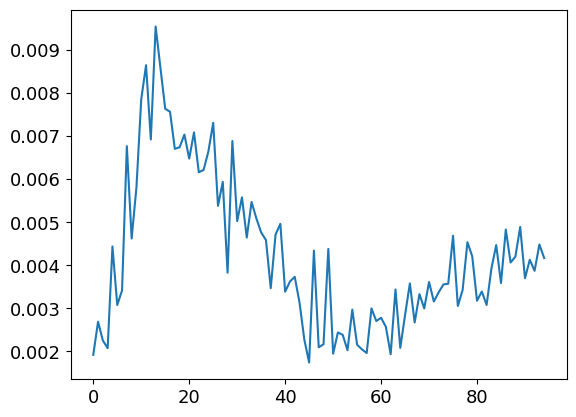

In [34]:
plt.plot(loss_list)

In [35]:
@jit 
def time_integration_for_langevin(params, key):
    t_end = 10**params['t_end']
    return time_integration_tend_grad(t_end, key)


## Lagevin sampling

In [36]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [37]:
lr = 1e-10 
learning_rates = {'t_end': lr}

In [38]:
params_MLE = {'t_end': jnp.log10(xlist[np.argmin(loss_list[1:])])}
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE,500,1e-7,rng_key)

100%|██████████| 500/500 [02:51<00:00,  2.92it/s]


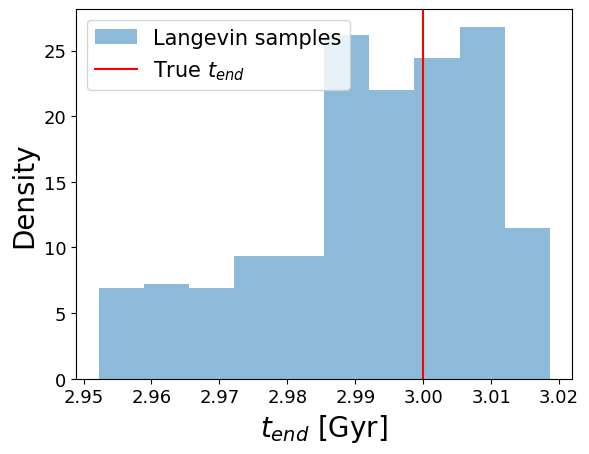

In [39]:
plt.hist([10**samp['t_end']*code_units.code_time.to(u.Gyr) for samp in out_samps], density=True, alpha=0.5, label='Langevin samples')
plt.axvline(params.t_end*code_units.code_time.to(u.Gyr), color='r', label='True $t_{end}$')
plt.xlabel("$t_{end}$ [Gyr]")
plt.ylabel("Density")
plt.legend()

# 2 PARAMETERTS


## Brute force 

In [14]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

target_norm, mean, std = normalize_stream_data(stream_target)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy

@jit
def time_integration_NFWM_tend_grad(M_NFW, t_end, key):



    key_Plummer, key_noise = jax.random.split(key, 2)
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params = new_params._replace(NFW_params = params.NFW_params._replace(Mvir = M_NFW,))
    new_params_com = params_com._replace(t_end = -t_end,)
    new_params_com = new_params_com._replace(NFW_params = params_com.NFW_params._replace(Mvir = M_NFW,))

    
    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])

    
    sim_norm = (stream - mean)/std
    
    # Adaptive bandwidth for 6D data
    # n_sim, n_target = len(stream), len(stream_target)
    # sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # # Compute MMD terms
    # xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    # yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    # xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    # return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.1, 0.1, 0.1, 0.6])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)

In [15]:
bounds_mass = jnp.log10(np.array([1e11, 1e12]) * u.Msun.to(code_units.code_mass)) # in code units
bound_time = jnp.log10(np.array([5e-3, 5]) * u.Gyr.to(code_units.code_time)) # in code units

@jit 
def normalize_Mvir_and_t_end(Mvir_and_t_end):
    # Mvir, t_end = Mvir_and_t_end
    Mvir, t_end = jnp.log10(Mvir_and_t_end)
    # Normalize Mvir to [-1, 1]
    Mvir_norm = (Mvir - bounds_mass[0]) / (bounds_mass[1] - bounds_mass[0])
    # Normalize t_end to [-1, 1]
    t_end_norm = (t_end - bound_time[0]) / (bound_time[1] - bound_time[0]) 
    return jnp.array([Mvir_norm, t_end_norm])

@jit
def de_normalize_Mvir_and_t_end(Mvir_and_t_end_norm):
    Mvir_norm, t_end_norm = Mvir_and_t_end_norm
    # De-normalize Mvir to original scale
    Mvir = Mvir_norm * (bounds_mass[1] - bounds_mass[0]) + bounds_mass[0]
    Mvir = jnp.power(10, Mvir)
    # De-normalize t_end to original scale
    t_end = t_end_norm * (bound_time[1] - bound_time[0]) + bound_time[0]
    t_end = jnp.power(10, t_end)
    return jnp.array([Mvir, t_end])

    
@jit
def time_integration_for_gradient_descend(Mvir_and_t_end, key):
    # Mvir, t_end = de_normalize_Mvir_and_t_end(Mvir_and_t_end)
    Mvir, t_end = Mvir_and_t_end
    Mvir = 10**Mvir  # Convert back to original scale
    t_end = 10**t_end
    return (time_integration_NFWM_tend_grad)(Mvir, t_end, key)

## Brute force minimum search

In [20]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
Mvir = (params.NFW_params.Mvir*(3/4) * u.Msun).to(code_units.code_mass).value
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(lambda Mvir, t_end, key: time_integration_NFWM_tend_grad(jnp.log10(Mvir), jnp.log10(t_end), key), argnums=(0,1))(Mvir, t_end, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)  

n_sim = 10

# M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales

M_tot_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim-1,), minval=params.NFW_params.Mvir*(1/4), maxval=params.NFW_params.Mvir*(8/4))  # Random values in the range
t_end_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim-1,), minval=params.t_end * (1/4), maxval=params.t_end * (8/4))  # Random values in the range

M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# Ensure both arrays are sorted
M_tot_values = jnp.sort(M_tot_values)
t_end_values = jnp.sort(t_end_values)


# Create a meshgrid
M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# Flatten the grid for vectorized computation
Mvir_flat = M_tot_grid.flatten()
t_end_flat = t_end_grid.flatten()
keys_flat = jax.random.split(random.PRNGKey(0), len(Mvir_flat))  # Create a flat array of keys

mesh = Mesh(np.array(jax.devices()), ("i",))
Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


@jit
def time_integration_for_laxmap(input):
    Mvir, t_end, key = input
    return jax.value_and_grad(time_integration_for_gradient_descend,)((jnp.log10(Mvir), jnp.log10(t_end)), key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
                         xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
                         batch_size=2)


Gradient of the total mass of the Mvir of NFW:
 (Array(4.7812872e-14, dtype=float32), Array(0.1723434, dtype=float32))
Loss:
 0.23656166


Minimum loss: 0.0021333754993975163, Mvir: 436833255424.0, t_end: 3.0


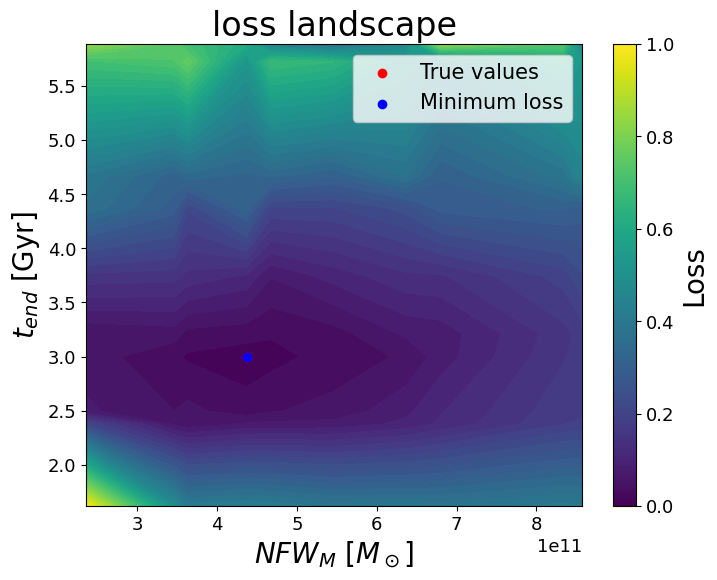

In [22]:
loss_min, min_index = jnp.min(loss), jnp.argmin(loss)
Mvir_min = M_tot_values[min_index // n_sim]
t_end_min = t_end_values[min_index % n_sim]
print(f"Minimum loss: {loss_min}, Mvir: {Mvir_min * code_units.code_mass.to(u.Msun)}, t_end: {t_end_min * code_units.code_time.to(u.Gyr)}")
loss = loss.reshape(M_tot_grid.shape)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.contourf(M_tot_values*code_units.code_mass.to(u.Msun), t_end_values*code_units.code_time.to(u.Gyr), loss.T, levels=50, cmap="viridis")
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), params.t_end * code_units.code_time.to(u.Gyr),color="red", label="True values")
plt.scatter(Mvir_min * code_units.code_mass.to(u.Msun), t_end_min * code_units.code_time.to(u.Gyr), color="blue", label="Minimum loss")
plt.colorbar(label="Loss")
plt.xlabel("$NFW_{M}$ [$M_\odot$]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.title("loss landscape")
plt.legend()


In [23]:
grad[0].reshape(M_tot_grid.shape).shape

(10, 10)

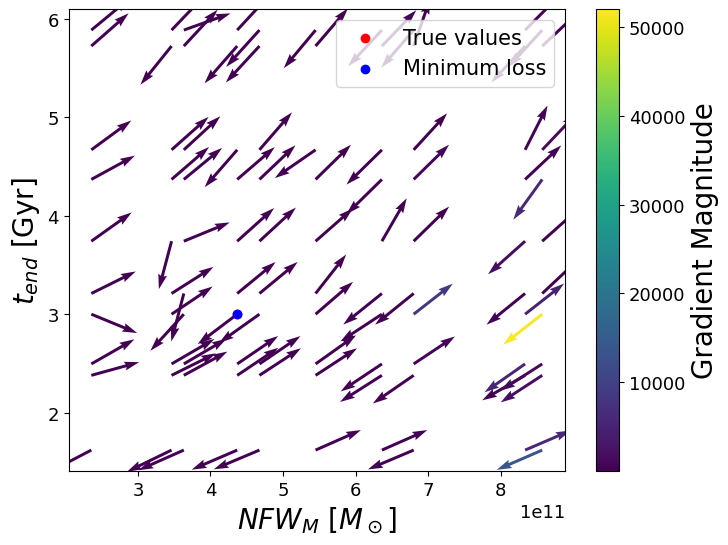

In [27]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
quiver = ax.quiver(M_tot_values * code_units.code_mass.to(u.Msun),
           t_end_values * code_units.code_time.to(u.Gyr),
           grad[0].reshape(M_tot_grid.shape)/jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           grad[1].reshape(M_tot_grid.shape)/jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           jnp.sqrt(grad[0]**2 + grad[1]**2).reshape(M_tot_grid.shape),
           scale=10, alpha=1, cmap='viridis')
ax.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
            params.t_end * code_units.code_time.to(u.Gyr), color="red", label="True values")
ax.scatter(Mvir_min * code_units.code_mass.to(u.Msun),
            t_end_min * code_units.code_time.to(u.Gyr), color="blue", label="Minimum loss")
# Add colorbar
cbar = plt.colorbar(quiver, ax=ax)
cbar.set_label('Gradient Magnitude')
ax.set_ylabel("$t_{end}$ [Gyr]")
ax.set_xlabel("$NFW_{M}$ [$M_\odot$]")
ax.legend()

## Gradient descend

In [28]:
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm



# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(-f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list

In [29]:
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_for_gradient_descend, 
    jnp.array([jnp.log10(Mvir_min), jnp.log10(t_end_min)]),
    random.PRNGKey(0), 
    learning_rate=0.01,
    tol=1e-12, 
    max_iter=100)

100%|██████████| 100/100 [01:45<00:00,  1.05s/it]


In [30]:
x1 = 10**x1  # Convert back to original scale
xlist = 10**jnp.array(xlist)  # Convert back to original scale

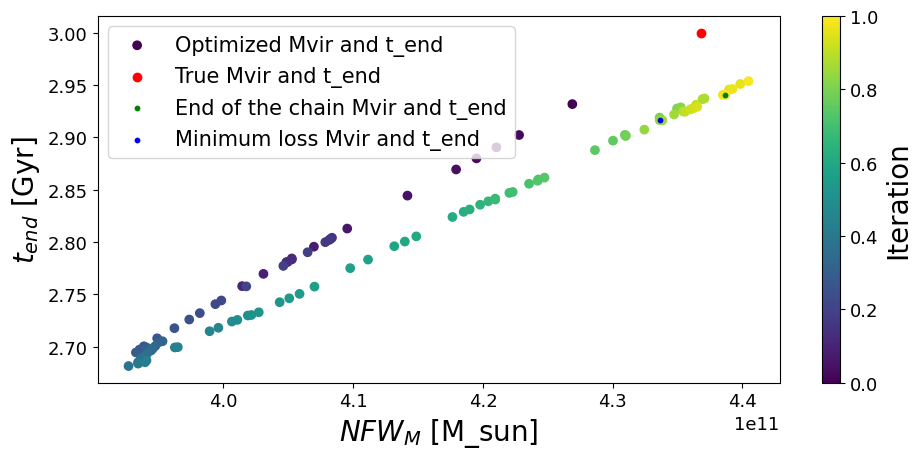

In [31]:
plt.figure(figsize=(10, 5), tight_layout=True)
plt.scatter(xlist[1:][:, 0] * code_units.code_mass.to(u.Msun),
            xlist[1:][:, 1] * code_units.code_time.to(u.Gyr), 
            c=jnp.arange(len(xlist[1:])) ,label='Optimized Mvir and t_end')
plt.scatter(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun),
            params.t_end * code_units.code_time.to(u.Gyr), label='True Mvir and t_end', color='r')
plt.scatter(x1[0] * code_units.code_mass.to(u.Msun),
            x1[1] * code_units.code_time.to(u.Gyr), 
            s=10, label='End of the chain Mvir and t_end', color='g')
plt.scatter(xlist[np.argmin(loss_list)][0] * code_units.code_mass.to(u.Msun),
            xlist[np.argmin(loss_list)][1] * code_units.code_time.to(u.Gyr), 
            s=10, label='Minimum loss Mvir and t_end', color='b')
plt.xlabel("$NFW_M$ [M_sun]")
plt.ylabel("$t_{end}$ [Gyr]")
plt.colorbar(label='Iteration')
plt.legend()

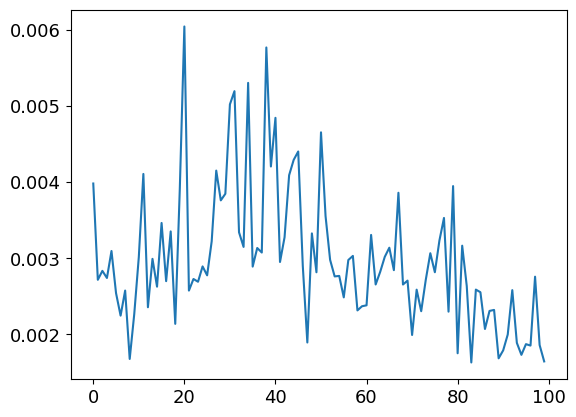

In [32]:
plt.plot(loss_list)

## Langevine sampling

In [33]:
@jit 
def time_integration_for_langevin(params, key):
    Mvir = 10**params['Mvir']
    t_end = 10**params['t_end']
    return time_integration_NFWM_tend_grad(Mvir, t_end, key)


In [34]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [35]:
lr = 1e-5
learning_rates = {'t_end': lr,
                  'Mvir': lr}

In [38]:
params_MLE = {'t_end': jnp.log10(t_end_min),
              'Mvir': jnp.log10(Mvir_min)}  
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE, 2000, 1e-7, rng_key)

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [11:03<00:00,  3.01it/s]


Parameter Mvir in chain Langevin samples is not constrained
Parameter t_end in chain Langevin samples is not constrained


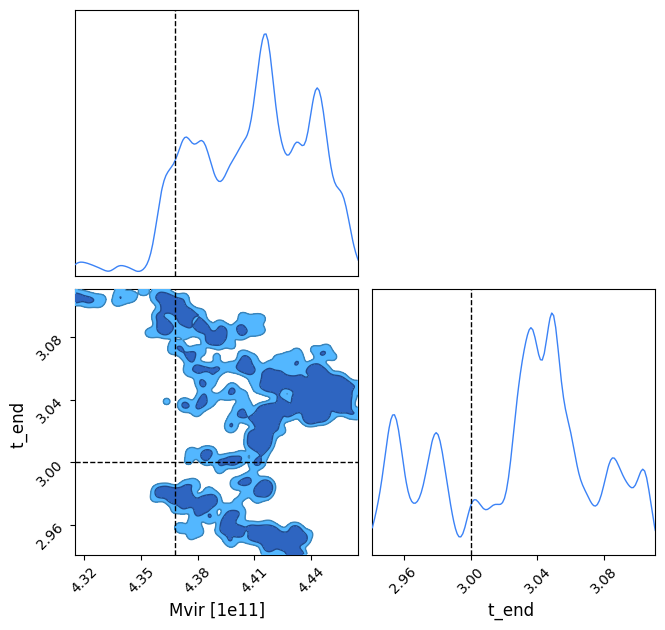

In [42]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(out_samps[500::2], columns=['Mvir', 't_end'])
df['Mvir'] = 10**df['Mvir'] * code_units.code_mass.to(u.Msun)
df['Mvir'] = df['Mvir'].astype(float)
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['t_end'] = df['t_end'].astype(float) 
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'Mvir': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

## Microcanonical Langevine MCMC

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["font.size"] = 19

import jax
import blackjax
import numpy as np
import jax.numpy as jnp
from datetime import date
import numpyro
import numpyro.distributions as dist

from numpyro.infer.util import initialize_model

rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [ ]:
def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=True,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key

In [67]:
# run the algorithm on a high dimensional gaussian, and show two of the dimensions
#TO BE CHANGED THE RNG KEY


logdensity_fn = lambda params: time_integration_for_gradient_descend(params, key=rng_key)
num_steps = 1000
transform = lambda state, info: state.position[:2]
params_MLE = jnp.log10(np.array([Mvir_min, t_end_min]))  # Initial position in log scale  

sample_key, rng_key = jax.random.split(rng_key)
samples, initial_state, params, chain_key = run_mclmc(
    logdensity_fn=logdensity_fn,
    num_steps=num_steps,
    initial_position=params_MLE,
    key=sample_key,
    transform=transform,
)
samples.mean()

Array(4.129422, dtype=float32)

In [78]:
jnp.log10(Mvir_min)

Array(7.63249, dtype=float32)

Text(0.5, 1.0, 'Scatter Plot of Samples')

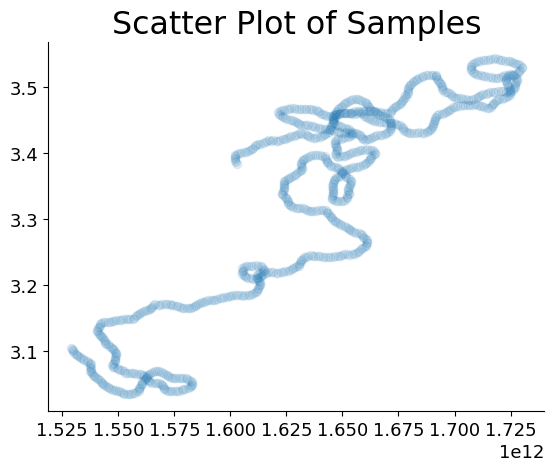

In [ ]:
plt.scatter(x=10**samples[:, 0]* code_units.code_mass.to(u.Msun), 
            y=10**samples[:, 1]* code_units.code_time.to(u.Gyr), alpha=0.1)
plt.title("Scatter Plot of Samples")

In [74]:
10**samples[:, 0]* code_units.code_mass.to(u.Msun), 

(Array([1.6030339e+12, 1.6025974e+12, 1.6021435e+12, 1.6019114e+12,
        1.6020802e+12, 1.6021857e+12, 1.6022456e+12, 1.6030269e+12,
        1.6038014e+12, 1.6048935e+12, 1.6059864e+12, 1.6069107e+12,
        1.6077226e+12, 1.6085877e+12, 1.6094533e+12, 1.6101957e+12,
        1.6109454e+12, 1.6115329e+12, 1.6123753e+12, 1.6133989e+12,
        1.6144018e+12, 1.6152422e+12, 1.6162142e+12, 1.6171303e+12,
        1.6181605e+12, 1.6192125e+12, 1.6203152e+12, 1.6214186e+12,
        1.6223125e+12, 1.6233923e+12, 1.6244157e+12, 1.6252613e+12,
        1.6262359e+12, 1.6272611e+12, 1.6282798e+12, 1.6291525e+12,
        1.6300255e+12, 1.6310568e+12, 1.6321066e+12, 1.6331032e+12,
        1.6340647e+12, 1.6348507e+12, 1.6356801e+12, 1.6366537e+12,
        1.6377323e+12, 1.6387289e+12, 1.6397979e+12, 1.6408066e+12,
        1.6416065e+12, 1.6423205e+12, 1.6433052e+12, 1.6438214e+12,
        1.6442005e+12, 1.6444967e+12, 1.6448613e+12, 1.6450637e+12,
        1.6455152e+12, 1.6456308e+12, 1.6457575e

In [69]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(samples, columns=['Mvir', 't_end'])
df['Mvir'] = 10**df['Mvir'] * code_units.code_mass.to(u.Msun)
df['Mvir'] = df['Mvir'].astype(float)
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['t_end'] = df['t_end'].astype(float) 
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'Mvir': params.NFW_params.Mvir* code_units.code_mass.to(u.Msun), 
                            't_end': params.t_end* code_units.code_time.to(u.Gyr)}), )
fig = c.plotter.plot()

AttributeError: 'MCLMCAdaptationState' object has no attribute 'NFW_params'

## NUTS sampling

# Multi dimensional (7 params)

## Brute force

In [43]:
# Gradient on t_end 
# for now we will only use the last snapshot to caluclate the loss and the gradient
config =  config._replace(return_snapshots=False,)
config_com = config_com._replace(return_snapshots=False,)
stream_target = s

def normalize_data(X):
    """Z-score normalization"""
    mean = jnp.mean(X, axis=0)
    std = jnp.std(X, axis=0)
    return (X - mean) / std, mean, std

# Your stream data: [R, phi1, phi2, vR, v1_cosphi2, v2]
def normalize_stream_data(stream):
    """Normalize stellar stream data for RBF"""
    
    # Remove NaN values first
    mask = ~jnp.isnan(stream).any(axis=1)
    stream_clean = stream[mask]
    
    # Normalize each dimension
    stream_norm, mean, std = normalize_data(stream_clean)
    
    return stream_norm, mean, std

target_norm, mean, std = normalize_stream_data(stream_target)

@jit
def rbf_kernel(x, y, sigma):
    """RBF kernel optimized for 6D astronomical data"""
    return jnp.exp(-jnp.sum((x - y)**2) / (2 * sigma**2))

@jit 
def compute_mmd(sim_norm, target_norm, sigmas):
    xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigmas))(sim_norm))(sim_norm))
    yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigmas))(target_norm))(target_norm))
    xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigmas))(target_norm))(sim_norm))
    return xx + yy - 2 * xy

@jit
def time_integration_grad(t_end, 
                          M_plummer,
                          a_plummer,
                          M_NFW, 
                          rs_NFW,
                          M_MN,
                          a_MN,
                          key):


    key_Plummer, key_noise = jax.random.split(key, 2)
    #we set up the parameters of the simulations, changing only the parameter that we want to optimize
    new_params = params._replace(t_end = t_end,)
    new_params = new_params._replace(NFW_params = params.NFW_params._replace(Mvir = M_NFW, r_s = rs_NFW,))
    new_params = new_params._replace(MN_params = params.MN_params._replace(M = M_MN, a = a_MN,))
    new_params = new_params._replace(Plummer_params = params.Plummer_params._replace(Mtot = M_plummer, a = a_plummer,))

    new_params_com = params_com._replace(t_end = -t_end,)
    new_params_com = new_params_com._replace(NFW_params = params_com.NFW_params._replace(Mvir = M_NFW, r_s = rs_NFW,))
    new_params_com = new_params_com._replace(MN_params = params_com.MN_params._replace(M = M_MN, a = a_MN,))
    new_params_com = new_params_com._replace(Plummer_params = params_com.Plummer_params._replace(Mtot = M_plummer, a = a_plummer,))
    

    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    mass_com = jnp.array([params.Plummer_params.Mtot]) 
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)
    #we run the simulation backwards in time for the center of mass
    final_state_com = time_integration(initial_state_com, mass_com, config=config_com, params=new_params_com)
    #we calculate the final position and velocity of the center of mass
    pos_com = final_state_com[:, 0]
    vel_com = final_state_com[:, 1]

    #we construct the initial state of the Plummer sphere
    positions, velocities, mass = Plummer_sphere(key=key_Plummer, params=new_params, config=config)
    #we add the center of mass position and velocity to the Plummer sphere particles
    positions = positions + pos_com
    velocities = velocities + vel_com
    #initialize the initial state
    initial_state_stream = construct_initial_state(positions, velocities, )
    #run the simulation
    final_state = time_integration(initial_state_stream, mass, config=config, params=new_params)

    #projection on the GD1 stream
    stream = projection_on_GD1(final_state, code_units=code_units,)
    #add gaussian noise to the stream
    noise_std = jnp.array([0.25, 0.001, 0.15, 5., 0.1, 0.0])
    stream = stream + jax.random.normal(key=key_noise, shape=stream.shape) * noise_std
    #we calculate the loss as the negative log likelihood of the stream

     # Normalize to standard ranges for each dimension
    bounds = jnp.array([
        [6, 20],        # R [kpc]
        [-120, 70],     # phi1 [deg]  
        [-8, 2],        # phi2 [deg]
        [-250, 250],    # vR [km/s]
        [-2., 1.0],     # v1_cosphi2 [mas/yr]
        [-0.10, 0.10]   # v2 [mas/yr]
    ])

    
    sim_norm = (stream - mean)/std
    
    # Adaptive bandwidth for 6D data
    # n_sim, n_target = len(stream), len(stream_target)
    # sigma = 0.5 * jnp.power(n_sim + n_target, -1/(6+4))  # Rule of thumb for 6D
    
    # # Compute MMD terms
    # xx = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda xj: rbf_kernel(xi, xj, sigma))(sim_norm))(sim_norm))
    # yy = jnp.mean(jax.vmap(lambda yi: jax.vmap(lambda yj: rbf_kernel(yi, yj, sigma))(target_norm))(target_norm))
    # xy = jnp.mean(jax.vmap(lambda xi: jax.vmap(lambda yj: rbf_kernel(xi, yj, sigma))(target_norm))(sim_norm))
    
    # return xx + yy - 2 * xy

    distances = jax.vmap(lambda x: jax.vmap(lambda y: jnp.linalg.norm(x - y))(target_norm))(sim_norm)
    distance_flat = distances.flatten()

    # Use percentiles as natural scales
    sigmas = jnp.array([
        jnp.percentile(distance_flat, 10),   # Fine scale
        jnp.percentile(distance_flat, 25),   # Small scale  
        jnp.percentile(distance_flat, 50),   # Medium scale (median)
        jnp.percentile(distance_flat, 75),   # Large scale
        jnp.percentile(distance_flat, 90),   # Very large scale
    ])

    # Adaptive weights based on scale separation
    scale_weights = jnp.array([0.1, 0.1, 0.1, 0.1, 0.6])
    scale_weights = jnp.ones_like(sigmas)  # Equal weights for simplicity

    # Compute MMD with multiple kernels
    mmd_total = jnp.sum(scale_weights * jax.vmap(lambda sigma: compute_mmd(sim_norm, target_norm, sigma))(sigmas))
    
    return mmd_total / len(sigmas)

In [44]:
bounds_mass = jnp.log10(np.array([1e11, 1e12]) * u.Msun.to(code_units.code_mass)) # in code units
bound_time = jnp.log10(np.array([5e-3, 5]) * u.Gyr.to(code_units.code_time)) # in code units

@jit 
def normalize_Mvir_and_t_end(Mvir_and_t_end):
    # Mvir, t_end = Mvir_and_t_end
    Mvir, t_end = jnp.log10(Mvir_and_t_end)
    # Normalize Mvir to [-1, 1]
    Mvir_norm = (Mvir - bounds_mass[0]) / (bounds_mass[1] - bounds_mass[0])
    # Normalize t_end to [-1, 1]
    t_end_norm = (t_end - bound_time[0]) / (bound_time[1] - bound_time[0]) 
    return jnp.array([Mvir_norm, t_end_norm])

@jit
def de_normalize_Mvir_and_t_end(Mvir_and_t_end_norm):
    Mvir_norm, t_end_norm = Mvir_and_t_end_norm
    # De-normalize Mvir to original scale
    Mvir = Mvir_norm * (bounds_mass[1] - bounds_mass[0]) + bounds_mass[0]
    Mvir = jnp.power(10, Mvir)
    # De-normalize t_end to original scale
    t_end = t_end_norm * (bound_time[1] - bound_time[0]) + bound_time[0]
    t_end = jnp.power(10, t_end)
    return jnp.array([Mvir, t_end])

    
@jit
def time_integration_for_gradient_descend(params, key):
    # Mvir, t_end = de_normalize_Mvir_and_t_end(Mvir_and_t_end)
    t_end, M_plummer, a_plummer, M_NFW, rs_NFW, M_MN, a_MN = params
    t_end = 10**t_end
    M_plummer = 10**M_plummer
    a_plummer = 10**a_plummer
    M_NFW = 10**M_NFW
    M_MN = 10**M_MN 
    rs_NFW = 10**rs_NFW
    a_MN = 10**a_MN
    return time_integration_grad(t_end,
                                   M_plummer,
                                   a_plummer,
                                   M_NFW, 
                                   rs_NFW,
                                   M_MN,
                                   a_MN,
                                   key)

## Brute force minimum search

In [ ]:
# Calculate the value of the function and the gradient wrt the total mass of the plummer sphere
t_end = (params.t_end * (5/4) * u.Gyr).to(code_units.code_time).value  # Example: 25% increase in t_end
M_plummer = (params.Plummer_params.Mtot * (3/4) * u.Msun).to(code_units.code_mass).value
a_plummer = (params.Plummer_params.a * (3/4) * u.kpc).to(code_units.code_length).value
M_NFW = (params.NFW_params.Mvir * (3/4) * u.Msun).to(code_units.code_mass).value
rs_NFW = (params.NFW_params.r_s * (3/4) * u.kpc).to(code_units.code_length).value
M_MN = (params.MN_params.M * (3/4) * u.Msun).to(code_units.code_mass).value
a_MN = (params.MN_params.a * (3/4) * u.kpc).to(code_units.code_length).value
key = random.PRNGKey(0)
loss, grad = jax.value_and_grad(lambda t_end, M_plummer, a_plummer, M_NFW, rs_NFW, M_MN, a_MN, key: time_integration_grad(jnp.log10(t_end),
                                                                                  jnp.log10(M_plummer),
                                                                                  jnp.log10(a_plummer),
                                                                                  jnp.log10(M_NFW),
                                                                                  jnp.log10(rs_NFW),
                                                                                  jnp.log10(M_MN),
                                                                                  jnp.log10(a_MN),
                                                                                  key),
                                 argnums=(0,1,2,3,4,5,6))(t_end, M_plummer, a_plummer, M_NFW, rs_NFW, M_MN, a_MN, key)
print("Gradient of the total mass of the Mvir of NFW:\n", grad)
print("Loss:\n", loss)


### GRID SEARCH 
n_sim = 3

# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales
# M_plummer_values = jnp.linspace(params.Plummer_params.Mtot*(1/4), params.Plummer_params.Mtot*(8/4), n_sim-1)  # Adjust range based on expected values
# a_plummer_values = jnp.linspace(params.Plummer_params.a*(1/4), params.Plummer_params.a*(8/4), n_sim-1)  # Adjust range based on expected values
# M_NFW_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1)  # Adjust range based on expected values
# rs_NFW_values = jnp.linspace(params.NFW_params.r_s*(1/4), params.NFW_params.r_s*(8/4), n_sim-1)  # Adjust range based on expected values
# M_MN_values = jnp.linspace(params.MN_params.M*(1/4), params.MN_params.M*(8/4), n_sim-1)  # Adjust range based on expected values
# a_MN_values = jnp.linspace(params.MN_params.a*(1/4), params.MN_params.a*(8/4), n_sim-1)  # Adjust range based on expected values
t_end_values = jax.random.uniform(random.PRNGKey(0), shape=(n_sim-1,), minval=params.t_end * (1/4), maxval=params.t_end * (8/4))  # Random values in the range
M_plummer_values = jax.random.uniform(random.PRNGKey(1), shape=(n_sim-1,), minval=params.Plummer_params.Mtot*(1/4), maxval=params.Plummer_params.Mtot*(8/4))  # Random values in the range
a_plummer_values = jax.random.uniform(random.PRNGKey(2), shape=(n_sim-1,), minval=params.Plummer_params.a*(1/4), maxval=params.Plummer_params.a*(8/4))  # Random values in the range
M_NFW_values = jax.random.uniform(random.PRNGKey(3), shape=(n_sim-1,), minval=params.NFW_params.Mvir*(1/4), maxval=params.NFW_params.Mvir*(8/4))  # Random values in the range
rs_NFW_values = jax.random.uniform(random.PRNGKey(4), shape=(n_sim-1,), minval=params.NFW_params.r_s*(1/4), maxval=params.NFW_params.r_s*(8/4))  # Random values in the range
M_MN_values = jax.random.uniform(random.PRNGKey(5), shape=(n_sim-1,), minval=params.MN_params.M*(1/4), maxval=params.MN_params.M*(8/4))  # Random values in the range
a_MN_values = jax.random.uniform(random.PRNGKey(6), shape=(n_sim-1,), minval=params.MN_params.a*(1/4), maxval=params.MN_params.a*(8/4))  # Random values in the range
# Append the true values to the arrays
t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
M_plummer_values = jnp.concatenate([M_plummer_values, jnp.array([params.Plummer_params.Mtot])])  # Append the true Mtot value
a_plummer_values = jnp.concatenate([a_plummer_values, jnp.array([params.Plummer_params.a])])  # Append the true a value
M_NFW_values = jnp.concatenate([M_NFW_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
rs_NFW_values = jnp.concatenate([rs_NFW_values, jnp.array([params.NFW_params.r_s])])  # Append the true r_s value
M_MN_values = jnp.concatenate([M_MN_values, jnp.array([params.MN_params.M])])  # Append the true Mtot value
a_MN_values = jnp.concatenate([a_MN_values, jnp.array([params.MN_params.a])])  # Append the true a value
# Ensure all arrays are sorted
t_end_values = jnp.sort(t_end_values)
M_plummer_values = jnp.sort(M_plummer_values)
a_plummer_values = jnp.sort(a_plummer_values)
M_NFW_values = jnp.sort(M_NFW_values)
rs_NFW_values = jnp.sort(rs_NFW_values)
M_MN_values = jnp.sort(M_MN_values)
a_MN_values = jnp.sort(a_MN_values)
# Create a meshgrid
M_plummer_grid, a_plummer_grid, t_end_grid, M_NFW_grid, rs_NFW_grid, M_MN_grid, a_MN_grid = jnp.meshgrid(
    M_plummer_values, a_plummer_values, t_end_values, M_NFW_values, rs_NFW_values, M_MN_values, a_MN_values, indexing="ij")
# Flatten the grid for vectorized computation
M_plummer_flat = M_plummer_grid.flatten()
a_plummer_flat = a_plummer_grid.flatten()
t_end_flat = t_end_grid.flatten()
M_NFW_flat = M_NFW_grid.flatten()
rs_NFW_flat = rs_NFW_grid.flatten()
M_MN_flat = M_MN_grid.flatten()
a_MN_flat = a_MN_grid.flatten()
keys_flat = jax.random.split(random.PRNGKey(0), len(M_plummer_flat))  # Create a flat array of keys
mesh = Mesh(np.array(jax.devices()), ("i",))
M_plummer_sharded = jax.device_put(M_plummer_flat, NamedSharding(mesh, PartitionSpec("i")))
a_plummer_sharded = jax.device_put(a_plummer_flat, NamedSharding(mesh, PartitionSpec("i")))
t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
M_NFW_sharded = jax.device_put(M_NFW_flat, NamedSharding(mesh, PartitionSpec("i")))
rs_NFW_sharded = jax.device_put(rs_NFW_flat, NamedSharding(mesh, PartitionSpec("i")))
M_MN_sharded = jax.device_put(M_MN_flat, NamedSharding(mesh, PartitionSpec("i")))   
a_MN_sharded = jax.device_put(a_MN_flat, NamedSharding(mesh, PartitionSpec("i")))
keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))

@jit
def time_integration_for_laxmap(input):
    M_plummer, a_plummer, t_end, M_NFW, rs_NFW, M_MN, a_MN, key = input
    params = jnp.log10(jnp.array([M_plummer, a_plummer, t_end, M_NFW, rs_NFW, M_MN, a_MN]))
    return jax.value_and_grad(time_integration_for_gradient_descend)(params, key)

loss, grad = jax.lax.map(f=time_integration_for_laxmap,
                         xs=(M_plummer_sharded, a_plummer_sharded, t_end_sharded,
                              M_NFW_sharded, rs_NFW_sharded, M_MN_sharded, a_MN_sharded, keys_sharded),
                         batch_size=1)

# M_tot_values = jnp.linspace(params.NFW_params.Mvir*(1/4), params.NFW_params.Mvir*(8/4), n_sim-1) # Adjust range based on expected values
# t_end_values = jnp.linspace(params.t_end * (1/4), params.t_end * (8/4), n_sim-1)   # Adjust range based on expected timescales


# M_tot_values = jnp.concatenate([M_tot_values, jnp.array([params.NFW_params.Mvir])])  # Append the true Mvir value
# t_end_values = jnp.concatenate([t_end_values, jnp.array([params.t_end])])  # Append the true t_end value
# # Ensure both arrays are sorted
# M_tot_values = jnp.sort(M_tot_values)
# t_end_values = jnp.sort(t_end_values)


# # Create a meshgrid
# M_tot_grid, t_end_grid,  = jnp.meshgrid(M_tot_values, t_end_values, indexing="ij")

# # Flatten the grid for vectorized computation
# Mvir_flat = M_tot_grid.flatten()
# t_end_flat = t_end_grid.flatten()
# keys_flat = jax.random.split(random.PRNGKey(0), len(Mvir_flat))  # Create a flat array of keys

# mesh = Mesh(np.array(jax.devices()), ("i",))
# Mvir_sharded = jax.device_put(Mvir_flat, NamedSharding(mesh, PartitionSpec("i")))
# t_end_sharded = jax.device_put(t_end_flat, NamedSharding(mesh, PartitionSpec("i")))
# keys_sharded = jax.device_put(keys_flat, NamedSharding(mesh, PartitionSpec("i")))


# @jit
# def time_integration_for_laxmap(input):
#     Mvir, t_end, key = input
#     return jax.value_and_grad(time_integration_for_gradient_descend,)((jnp.log10(Mvir), jnp.log10(t_end)), key)

# loss, grad = jax.lax.map(f=time_integration_for_laxmap, 
#                          xs=(Mvir_sharded, t_end_sharded, keys_sharded), 
#                          batch_size=5)


Gradient of the total mass of the Mvir of NFW:
 (Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32), Array(nan, dtype=float32))
Loss:
 nan


2025-06-18 23:13:26.213882: W external/xla/xla/hlo/transforms/simplifiers/hlo_rematerialization.cc:3022] Can't reduce memory use below 7.66GiB (8221435876 bytes) by rematerialization; only reduced to 22.54GiB (24207451252 bytes), down from 22.55GiB (24208817448 bytes) originally


In [17]:
loss_min, min_index = jnp.min(loss), jnp.argmin(loss)
M_plummer_min = M_plummer_values[min_index // (n_sim**6)]
a_plummer_min = a_plummer_values[(min_index // n_sim) % n_sim]
t_end_min = t_end_values[(min_index // (n_sim**5)) % n_sim]
M_NFW_min = M_NFW_values[(min_index // (n_sim**4)) % n_sim]
rs_NFW_min = rs_NFW_values[(min_index // (n_sim**3)) % n_sim]
M_MN_min = M_MN_values[(min_index // (n_sim**2)) % n_sim]
a_MN_min = a_MN_values[min_index % n_sim]
print(f"Minimum loss: {loss_min}, M_plummer: {M_plummer_min * code_units.code_mass.to(u.Msun)}, a_plummer: {a_plummer_min * code_units.code_length.to(u.kpc)}, t_end: {t_end_min * code_units.code_time.to(u.Gyr)}, M_NFW: {M_NFW_min * code_units.code_mass.to(u.Msun)}, rs_NFW: {rs_NFW_min * code_units.code_length.to(u.kpc)}, M_MN: {M_MN_min * code_units.code_mass.to(u.Msun)}, a_MN: {a_MN_min * code_units.code_length.to(u.kpc)}")

Minimum loss: 0.07072168588638306, M_plummer: 2805.046142578125, a_plummer: 0.001999999862164259, t_end: 3.0, M_NFW: 109208313856.0, rs_NFW: 4.0, M_MN: 17048476672.0, a_MN: 3.0


In [18]:
## Gradient descend
from jaxopt import ScipyMinimize, LBFGS
import optax
import optimistix as optx
from tqdm import tqdm



# from functools import partial
# @partial(jit, static_argnames=('func','learning_rate', 'tol', 'max_iter'))
def gradient_descent_optimization(func, x_init, key, learning_rate=20, tol=0.5, max_iter=2000):
    # xlist = jnp.zeros((max_iter + 1, x_init.shape[0]))
    xlist = []
    x = x_init
    loss_list = []
    # loss_list = jnp.zeros(max_iter + 1)

    xlist.append(x)
    # xlist = xlist.at[0].set(x)  # Initialize the first element with x_init

    # ADAM optimizer
    # optimizer = optax.adam(learning_rate=learning_rate)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAM
    # learning_rate_fn = optax.warmup_constant_schedule(peak_value=learning_rate, warmup_steps=10, init_value=0.0)
    # optimizer = optax.adam(learning_rate_fn, b1=0.)
    # optimizer = optax.contrib.schedule_free(optimizer, learning_rate_fn, b1=0.9)
    # optimizer_state = optimizer.init(x)

    #SCHEDULE FREE ADAMW
    optimizer = optax.contrib.schedule_free_adamw(learning_rate)
    optimizer_state = optimizer.init(x)


    for _ in tqdm(range(max_iter)):
        # Compute the function value and its gradient
        loss, f_grad = jax.value_and_grad(func)(x, key)
        loss_list.append(loss)
        # loss_list = loss_list.at[_].set(loss)
        
        # Update the parameter
        updates, optimizer_state = optimizer.update(f_grad, optimizer_state, x)
        x = optax.apply_updates(x, updates)
        key = random.split(key, 1)[0]  # Update the key for the next iteration
        xlist.append(x)
        # xlist = xlist.at[_ + 1].set(x)
        
        # Check convergence
        if jnp.linalg.norm(updates) < tol:
            break
    
    return x, xlist, loss_list
x1, xlist, loss_list = gradient_descent_optimization(
    time_integration_for_gradient_descend, 
    jnp.array([jnp.log10(M_plummer_min), jnp.log10(a_plummer_min), jnp.log10(t_end_min), 
               jnp.log10(M_NFW_min), jnp.log10(rs_NFW_min), jnp.log10(M_MN_min), jnp.log10(a_MN_min)]),
    random.PRNGKey(0), 
    learning_rate=0.01,
    tol=1e-12, 
    max_iter=100)

x1 = 10**x1  # Convert back to original scale
xlist = 10**jnp.array(xlist)  # Convert back to original scale

100%|██████████| 100/100 [02:08<00:00,  1.28s/it]


## Langevine 

In [20]:
@jit 
def time_integration_for_langevin(params, key):
    t_end = 10**params['t_end']
    M_plummer = 10**params['M_plummer']
    a_plummer = 10**params['a_plummer']
    M_NFW = 10**params['M_NFW']
    rs_NFW = 10**params['rs_NFW']
    M_MN = 10**params['M_MN']
    a_MN = 10**params['a_MN']
    key = random.PRNGKey(0)

    return time_integration_grad(t_end,
                                   M_plummer,
                                   a_plummer,
                                   M_NFW, 
                                   rs_NFW,
                                   M_MN,
                                   a_MN,
                                   key)


In [19]:
from tqdm import tqdm 

def langevin_sampler(initial_params, num_samples, step_size, rng_key):
    samples = []
    params = initial_params
    for i in tqdm(range(num_samples)):
        grads = jax.jacfwd(time_integration_for_langevin)(params, rng_key)
        noise = jax.random.normal(rng_key, shape=jnp.array(list(params.values())).shape)
        params = {k: v + 0.5 * step_size * grads[k] + jnp.sqrt(step_size) * noise[idx] for idx, (k, v) in enumerate(params.items())}
        samples.append(params)
        rng_key, _ = jax.random.split(rng_key)
    return samples

In [21]:
params_MLE = {'t_end': jnp.log10(t_end_min),
              'M_plummer': jnp.log10(M_plummer_min), 
              'a_plummer': jnp.log10(a_plummer_min),
              'M_NFW': jnp.log10(M_NFW_min), 
              'rs_NFW': jnp.log10(rs_NFW_min),
              'M_MN': jnp.log10(M_MN_min), 
              'a_MN': jnp.log10(a_MN_min)}
rng_key = random.PRNGKey(42)
out_samps = langevin_sampler(params_MLE, 1000, 1e-7, rng_key)

100%|██████████| 1000/1000 [07:00<00:00,  2.38it/s]


Parameter M_plummer in chain Langevin samples is not constrained
Parameter a_plummer in chain Langevin samples is not constrained
Parameter t_end in chain Langevin samples is not constrained
Parameter M_MN in chain Langevin samples is not constrained
Parameter a_MN in chain Langevin samples is not constrained


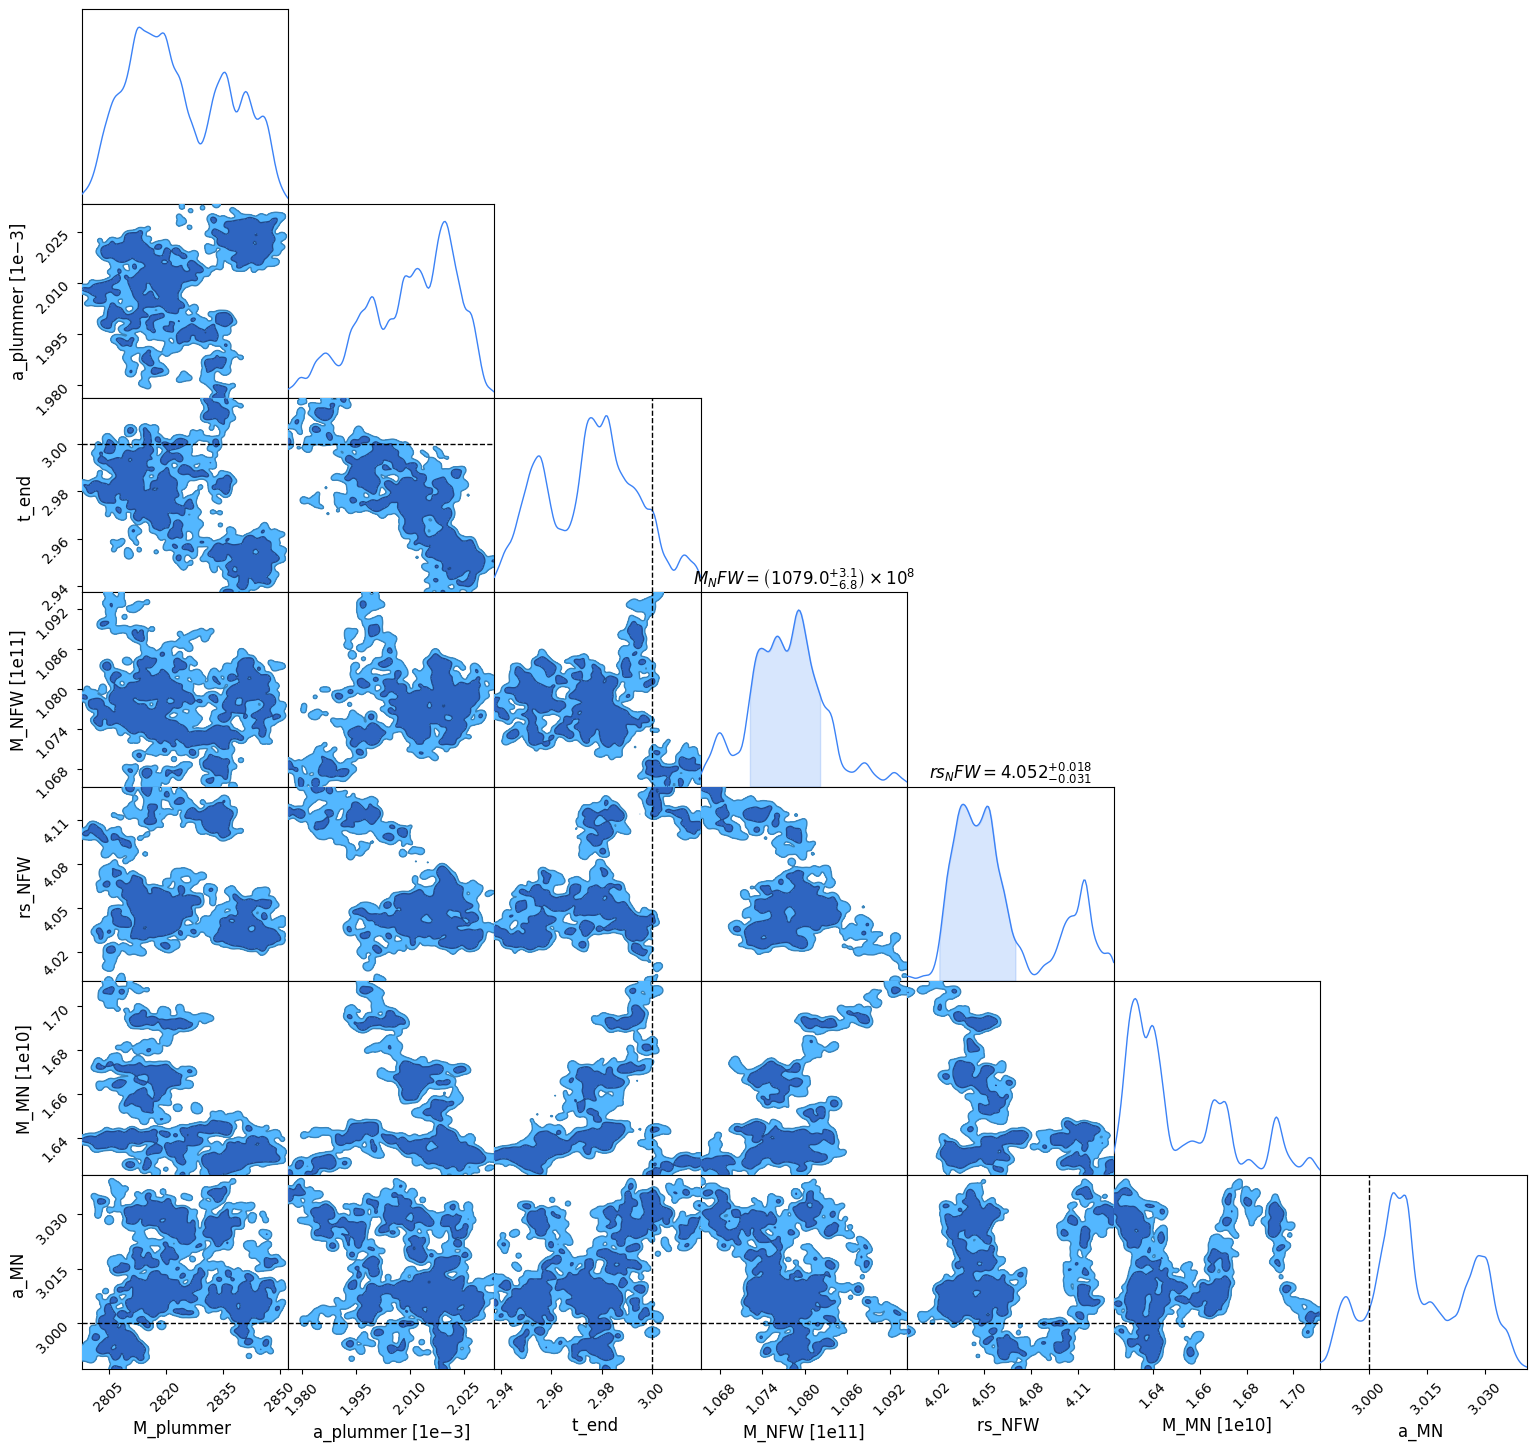

In [23]:
from chainconsumer import Chain, ChainConsumer, Truth
import pandas as pd

df = pd.DataFrame(out_samps, columns=['M_plummer', 'a_plummer', 't_end', 'M_NFW', 'rs_NFW', 'M_MN', 'a_MN'])
df['M_plummer'] = 10**df['M_plummer'] * code_units.code_mass.to(u.Msun)
df['a_plummer'] = 10**df['a_plummer'] * code_units.code_length.to(u.kpc)
df['t_end'] = 10**df['t_end'] * code_units.code_time.to(u.Gyr)
df['M_NFW'] = 10**df['M_NFW'] * code_units.code_mass.to(u.Msun) 
df['rs_NFW'] = 10**df['rs_NFW'] * code_units.code_length.to(u.kpc)
df['M_MN'] = 10**df['M_MN'] * code_units.code_mass.to(u.Msun)
df['a_MN'] = 10**df['a_MN'] * code_units.code_length.to(u.kpc)

df['M_plummer'] = df['M_plummer'].astype(float)
df['a_plummer'] = df['a_plummer'].astype(float)
df['t_end'] = df['t_end'].astype(float)
df['M_NFW'] = df['M_NFW'].astype(float)
df['rs_NFW'] = df['rs_NFW'].astype(float)
df['M_MN'] = df['M_MN'].astype(float)
df['a_MN'] = df['a_MN'].astype(float)
c = ChainConsumer()
c.add_chain(Chain(samples=df, name='Langevin samples'))
c.add_truth(Truth(location={'M_plummer': params.Plummer_params.Mtot * code_units.code_mass.to(u.Msun),
                            'a_plummer': params.Plummer_params.a * code_units.code_length.to(u.kpc),
                            't_end': params.t_end * code_units.code_time.to(u.Gyr),
                            'M_NFW': params.NFW_params.Mvir * code_units.code_mass.to(u.Msun),
                            'rs_NFW': params.NFW_params.r_s * code_units.code_length.to(u.kpc),
                            'M_MN': params.MN_params.M * code_units.code_mass.to(u.Msun),
                            'a_MN': params.MN_params.a * code_units.code_length.to(u.kpc)}), )
fig = c.plotter.plot()